In [4]:
# import library
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
import json

In [5]:
class Node:
  def __init__(self, weight, activation):
    self.weight = weight 
    self.activation = activation
    self.delta_w = 0

  def calculate(self, x):
    result = self.weight[0]
    for i in range(len(x)):
      result += x[i] * self.weight[i + 1]
    return result

  def update_weight(self):
    for i in range (len(self.weight)):
      self.weight[i] = self.weight[i] + self.delta_w[i]

  def update_delta_w(self, x):
    return learning_rate * self.delta_w * x

  # Define the Activation Functions
  def linear(self, net, derivative=False):
    if derivative:
        return 1
    else:
        return net

  def reLU(self, net, derivative=False):
    if derivative:
      if (net >= 0):
        return 1
      else:
        return 0
    else:
        return max(0, net)

  def sigmoid(self, net, derivative=False):
    if derivative:
        return self.sigmoid(net) * (1 - self.sigmoid(net))
    else:
        return 1 / (1 + math.exp(-net))

  def softmax(self, net_i, net, derivative=False):
    if derivative:
      return
    else:
      return math.exp(net_i) / sum([math.exp(x) for x in net])

In [6]:
class Layer:
  def __init__(self, neurons, activation_function):
    self.neurons = neurons
    self.activation_function = activation_function
  
  def get_num_neuron(self):
    return len(self.neurons)
  
  def update_weights():
    return

  def calculate_error(self, outputs, output_target):
    if self.activation_function == "softmax":
      error = self.cross_entropy_loss(outputs, output_target)
    else:
      error = self.sse_loss(outputs, output_target)
    return error

  # Define the Loss Functions
  def sse_loss(self, outputs, output_target):
    loss = 0
    for i in range(len(output_target)):
      loss += (output_target[i] - outputs[i]) ** 2
    return loss / 2

  def cross_entropy_loss(self, outputs, output_target):
    loss = 0
    for i in range(len(output_target)):
        loss = loss + (-1 * outputs[i] * np.log(output_target[i]))
    return loss

In [11]:
class BackPropagation:
  def __init__(self, model, layers, input, output_target, learning_rate, error_threshold, max_iter, batch_size):
    self.model = model
    self.layers = layers 
    self.input = input
    self.learning_rate = learning_rate
    self.error_threshold = error_threshold
    self.max_iter = max_iter
    self.batch_size = batch_size
    self.output_target = output_target
    self.outputs = []
    self.n_layers = len(layers)

  def forward_pass(self, layers, input):
    test_data = input 
    outputs = []
    outputs.append(test_data)
    node_input = test_data

    for layer in layers:
      node_output = []
      for node in layer.neurons:
        node_output.append(node.calculate(node_input))

      if (node.activation == "linear"):
        node_output = [node.linear(x) for x in node_output]
      elif (node.activation == "reLu" or node.activation=="relu"):
        node_output = [node.reLU(x) for x in node_output]
      elif (node.activation == "sigmoid"):
        node_output = [node.sigmoid(x) for x in node_output]
      elif (node.activation == "softmax"):
        softmax_output = [node.softmax(x, node_output) for x in node_output]
        node_output = softmax_output
      outputs.append(node_output)
      node_input = node_output

    ###### output ######
    # print("")
    for i in range(len(outputs)):
      # print("output layer ke", i+1)
      output_layer = outputs[i]
      for j in range(len(output_layer)):
        output_node = format(output_layer[j], '0.6f')
        # print("output node ke-" + str(j+1) + " :", output_node)
    return outputs
  
  def input_forward_pass(self, layers, input):
    count = 0
    outputs = []
    for i in input:
      output = self.forward_pass(layers, i)
      outputs.append(output)
      error = layers[self.n_layers-1].calculate_error(output[-1], self.output_target[count])
      print(error)
      count += 1
    self.outputs = outputs
    print("outputs: ", outputs)
    return error

  def backward_pass(self):
    save = [[[0 for k in range(self.layers[0].get_num_neuron())] for j in range(self.n_layers)] for i in range(self.batch_size)]
    for i in range(self.batch_size):
      print(self.n_layers)
      for j in range(self.n_layers-1, -1, -1):   #reminder for self: i = num of data(?), j = num of layers, k  = num of nodes in that layer, 
        # Output Layer
        if (j == self.n_layers-1):
          
          max_value = max(self.outputs[i][j+1])
          max_index = self.outputs[i][j+1].index(max_value)
                
                
          for k in range(self.layers[j].get_num_neuron()):
            if (self.layers[j].activation_function == "linear"):
              gradient = (self.output_target[i][k] - self.outputs[i][j+1][k]) * 1
            
            elif (self.layers[j].activation_function == "relu"):
              if (self.outputs[i][j+1][k] >= 0):
                gradient = (self.output_target[i][k] - self.outputs[i][j+1][k]) * 1
              else:
                gradient = 0
            
            elif (self.layers[j].activation_function == "sigmoid"):
              t = self.output_target[i][k]
              o = self.outputs[i][j+1][k]
              gradient = (t - o) * o * (1 - o)
            
            else: # softmax
              p = self.outputs[i][j+1][k]
              if(k==max_index):
                gradient = p
              else:
                gradient = -(1-p)
            #save gradient   #reminder for self: gradient is dEtot/do * do/dnet = dEtot/dnet
            save[i][j][k] = gradient
            
            
        #HIDDEN LAYER  
        else:   
          for k in range (self.layers[j].get_num_neuron()):
            de_per_dh = 0   #detot/dh
            
            for l in range (self.layers[j+1].get_num_neuron()): #reminder for self: l = num of nodes in next layer (THIS IS TO CALCULATE ALL dEo/dh)
                gradient = save[i][j+1][l]                          #dEtot/dnet
                weight = self.layers[j+1].neurons[l].weight[k+1]    #dnet/dh
                                                                    #dEo/dh = dEtot/dnet * dnet/dh  
                de_per_dh += weight * gradient                      #dEtot/dh = sum of dEo/dh
                
            if (self.layers[j].activation_function == "linear"):
              save[i][j][k] = de_per_dh * 1  #de/dh * dh/dnet = de/dnet
              
            elif (self.layers[j].activation_function == "relu"):
              if (self.outputs[i][j+1][k] >= 0):
                save[i][j][k] = de_per_dh * 1
              else:
                save[i][j][k] = 0            #de/dh * dh/dnet = de/dnet
                
            elif (self.layers[j].activation_function == "sigmoid"):
              o = self.outputs[i][j+1][k]  #net
              save[i][j][k] = de_per_dh * o * (1 - o)    #de/dh * dh/dnet = de/dnet
              
            else: # softmax
              pass
            
        
        # Update weights
    print("save", save) 
    for i in range(self.batch_size):
      for j in range(self.n_layers):   
        for k in range(self.layers[j].get_num_neuron()): 
          for l in range(len(self.layers[j].neurons[k].weight)):
            de_per_dnet = save[i][j][k]  #dEtot/dnet       
            
            if(l ==0): # bias
              dnet_per_dw = 1
            else:
              dnet_per_dw = self.outputs[i][j][l-1]  #dnet/dw
            if(j == 0 and k ==0 and l==0):
              print("b4:", self.layers[j].neurons[k].weight[l])
              print("de/dnet",de_per_dnet)
              print("dnet/dw",dnet_per_dw)
              print("lr",self.learning_rate)
            self.layers[j].neurons[k].weight[l] += self.learning_rate * de_per_dnet * dnet_per_dw  # w = w + learning_rate * dE/dnet * dnet/dw
            if(j == 0 and k ==0 and l==0):
              print("after:", self.layers[j].neurons[k].weight[l])


  def run_backprop(self):
    iteration = 0
    while True:
      err = self.input_forward_pass(self.layers, input)
      if(err <= self.error_threshold):
        print("error threshold reached")
        weights = self.getWeight()
        self.saveModel(weights, 0.0001)
        return
      
      if(iteration == self.max_iter):
        print("max iteration reached")
        weights = self.getWeight()
        self.saveModel(weights, 0.0001)
        return 
      
      self.backward_pass()
            
      iteration+=1

  def predict(self,x,layers):
    self.input_forward_pass(layers,x)
    print(self.outputs)

  def getWeight(self):
    weights = [[]]
    tmp = []
    for node in self.layers[0].neurons:
      tmp.append(node.weight)
    weights.append(tmp)
    return weights[1:]

  # Save Model
  def saveModel(self, weights, max_sse):
    data = {
      "case": {
          "model": self.model,
          "input": self.input,
          "weights": weights
      },
      "expect": {
          "output": self.output_target,
          "max_sse": max_sse
      }
    }
      
    with open('model.json', 'w') as f:
      json.dump(data, f)
      

In [8]:
# Load Model
def loadModel(filename):
  filepath = "test/" + filename
  if filename.endswith('.json'):
    try:
      with open(filepath, "r") as file:
        content = json.load(file)
    except:
      print("The file doesn't exist")
    
    model = content["case"]["model"]
    input = content["case"]["input"]
    output_target = content["case"]["target"]
    target_weights = content["expect"]["final_weights"]
    learning_rate = content["case"]["learning_parameters"]["learning_rate"]
    error_threshold = content["case"]["learning_parameters"]["error_threshold"]
    max_iter = content["case"]["learning_parameters"]["max_iteration"]
    batch_size = content["case"]["learning_parameters"]["batch_size"]

    layers_num = len(content["case"]["model"]["layers"])
    layers = []
    for i in range(layers_num):
      nodes = []
      nodes_num = content["case"]["model"]["layers"][i]["number_of_neurons"]
      activation = content["case"]["model"]["layers"][i]["activation_function"]
      
      init_weights_num = len(content["case"]["initial_weights"][i])
      for j in range(nodes_num):
        initial_weight = []
        
        for k in range(init_weights_num):
          weight = content["case"]["initial_weights"][i][k]
          initial_weight.append(weight[j])
        nodes.append(Node(initial_weight, activation))
      layers.append(Layer(nodes, activation))
      
    return model, layers, input, output_target, target_weights, learning_rate, error_threshold, max_iter, batch_size

  else :
    print("Format File must be .json or .txt")

In [9]:
def visualizeModel(layers):
    G = nx.Graph()
    ###### visualization ######
    #input 
    input_num = len(layers[0].neurons[0].weight) -1

    dict_pos = {} 
    
    g_counter = 1
    prev_layer_node_start = g_counter 
    G.add_node(g_counter,label = "B")
    dict_pos[g_counter] = (0,g_counter) 
    g_counter+=1
    
    for i in range(input_num):
      G.add_node(g_counter,label = "I"+str(g_counter-1))
      dict_pos[g_counter] = (0,g_counter) 
      g_counter+=1
      
    output_layer_id = len(layers)- 1

    

    for layer_id in range(len(layers)): #loop through all the layers
      if(layer_id != output_layer_id):
        offset = prev_layer_node_start  
        prev_layer_node_start = g_counter
        l_counter = 0

        G.add_node(g_counter,label = "B")
        dict_pos[g_counter] = (layer_id+1,l_counter+1) 
        l_counter+=1
        g_counter+=1
        
        for node in layers[layer_id].neurons:    #loop through all the nodes
          G.add_node(g_counter,label = "H"+str(layer_id+1)+str(l_counter))
          dict_pos[g_counter] = (layer_id+1,l_counter+1) 
          l_counter+=1
          g_counter+=1

          i=0
          for weights in node.weight:        #loop through all the weights in a node
            G.add_edge(offset+i,g_counter-1,label=round(weights,5)) 
            i+=1

          if(layers[layer_id].neurons.index(node) == len(layers[layer_id].neurons) - 1):
            plt.annotate(node.activation, xy=dict_pos[g_counter-1], xytext=(dict_pos[g_counter-1][0], dict_pos[g_counter-1][1]+0.2), ha='center',
             fontsize=12, fontweight='bold')

          
        
      else:
        offset = prev_layer_node_start  
        prev_layer_node_start = g_counter
        l_counter = 0
        
        for node in layers[layer_id].neurons:    #loop through all the nodes
          G.add_node(g_counter,label = "O"+str(l_counter+1))
          dict_pos[g_counter] = (layer_id+1,l_counter+1) 
          l_counter+=1
          g_counter+=1

          i=0
          for weights in node.weight:        #loop through all the weights in a node
            G.add_edge(offset+i,g_counter-1,label=round(weights,5)) 
            i+=1

          if(layers[layer_id].neurons.index(node) == len(layers[layer_id].neurons) - 1):
            plt.annotate(node.activation, xy=dict_pos[g_counter-1], xytext=(dict_pos[g_counter-1][0], dict_pos[g_counter-1][1]+0.2), ha='center',
             fontsize=12, fontweight='bold')
      
    #output

    # draw nodes and edges

    nx.set_node_attributes(G, dict_pos, 'pos')
    # draw node labels
    node_labels = nx.get_node_attributes(G, 'label')
    # nx.draw_networkx_labels(G, dict_pos, labels=node_labels)

    # draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, dict_pos, edge_labels, label_pos = 0.2, verticalalignment = "top",font_size=7)
    nx.draw(G, nx.get_node_attributes(G, 'pos'), labels=node_labels, font_weight='bold',font_size=7)


    # show the graph
    plt.axis('off')
    plt.show()

0.19162836988296109
0.2549645764157292
outputs:  [[[0.0, 0.0], [0.52497918747894, 0.549833997312478]], [[0.0, 0.1], [0.5473576181430894, 0.5523079095743253]]]
1
1
save [[[-0.10597962693789073, 0.1114235461366134]], [[0.11214543447989843, -0.13656579810980837]]]
b4: 0.1
de/dnet -0.10597962693789073
dnet/dw 1
lr 0.1
after: 0.08940203730621094
b4: 0.08940203730621094
de/dnet 0.11214543447989843
dnet/dw 1
lr 0.1
after: 0.10061658075420078
0.1919740982226355
0.2545210297075542
outputs:  [[[0.0, 0.0], [0.5251329455728766, 0.5492116072548001]], [[0.0, 0.1], [0.5475381591053837, 0.551652374189909]]]
max iteration reached


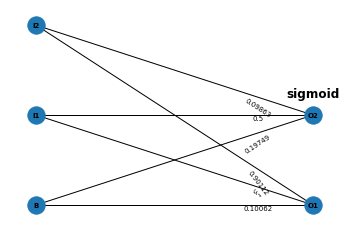

In [17]:
model, layers, input, output_target, target_weights, learning_rate, error_threshold, max_iter, batch_size = loadModel("sigmoid.json")
# print("layers", layers)
# print("input", input)
# print("output_target", output_target)
# print("target_weights", target_weights)
# print("learning_rate", learning_rate)
# print("error_threshold", error_threshold)
# print("max_iter", max_iter)
# print("batch_size", batch_size)
bp = BackPropagation(model, layers, input, output_target, learning_rate, error_threshold, max_iter, batch_size)
# print(bp.outputs)

# print(bp.outputs[0][1][1])
#visualizeModel(layers)
bp.run_backprop()
visualizeModel(layers)
# print(output)

### Load Iris Dataset

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA


In [ ]:
iris = datasets.load_iris()
X = iris.data 
y = iris.target

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X= sc.fit_transform(X)

### Training MLP Sklearn with Iris Dataset

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X, y)
y_pred = clf.predict(X)

### Training MLP Backpropagation with Iris Dataset

1.176584940629306
1.4774518117886681
1.4763994032784393
1.5197547226237644
1.3733563822143586
1.5136976247473062
1.6668634077043576
1.183551046911531
1.8985590389707814
1.2968954374311925
1.124029425103365
1.349516583760023
1.495239276229608
1.974385929775913
1.2992562118645077
2.7149632650387887
1.466633594624634
1.1927883641367805
1.0211956533574857
1.6268616578282946
0.8872911656103584
1.4572882648193586
1.9118136855124606
1.1199970555754966
1.3028742328524388
1.3385573290510002
1.2199992574278518
1.0806567549829456
1.0638542404053535
1.3720023016723903
1.3312103400456416
0.9314454170975065
2.3324182962602507
2.216199854211231
1.3150380419704553
1.3100721881691444
0.9423979524421856
1.4656674423267806
1.8473396305734413
1.1063748174637655
1.306735090026664
3.6710059566590516
1.775028300906799
1.4015923011799465
1.6969106776924774
1.559552139759091
1.6192736235918823
1.5304307787826736
1.2101429904477936
1.1938744997905613
0.7587041690198859
0.5523576127621183
0.5745080815045696
0.23

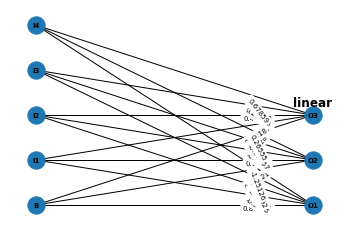

In [ ]:
def max_index(array):
    max = -999
    index = -1
    for i in range (len(array)):
        if(max <array[i]):
            max = array[i]
            index = i
    return index
layers, input, output_target, target_weights, learning_rate, error_threshold, max_iter, batch_size = loadModel("iris.json")
inputX = []
for i in X:
    array = []
    for j in i:
        array.append(j)
    inputX.append(array)
outputY = []
for i in y:
    if i == 0: 
        outputY.append([1.0,0.0,0.0])
    elif i ==1:
        outputY.append([0.0,1.0,0.0])
    else:
        outputY.append([0.0,0.0,1.0])
input = inputX
output_target = outputY
bp = BackPropagation(layers, input, output_target, learning_rate, error_threshold, max_iter, batch_size)
# print(bp.outputs)

# print(bp.outputs[0][1][1])
#visualizeModel(layers)
bp.run_backprop()
visualizeModel(layers)


In [ ]:
### Normalize the Output from Model Output

In [ ]:
normalize_input=[]
for i in bp.outputs:
    output = i[1]
    normalize_input.append(max_index(output))
print(normalize_input)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2]


normalize_input=[]
for i in bp.outputs:
    output = i[1]
    normalize_input.append(max_index(output))
print(normalize_input)

### Confusion Matrix MLP Sklearn

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,f1_score,make_scorer
from sklearn import metrics
cm = confusion_matrix(y, y_pred)
print(cm)
print("Accuracy : " +str(accuracy_score(y, y_pred)))
print("Recall : " + str(recall_score(y, y_pred,average='micro')))
print("F1 : " +str(f1_score(y, y_pred,average='micro')))

[[50  0  0]
 [ 0 49  1]
 [ 0  1 49]]
Accuracy : 0.9866666666666667
Recall : 0.9866666666666667
F1 : 0.9866666666666668


### Confusion Matrix MLP Backpropagation

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,f1_score,make_scorer
from sklearn import metrics
cm = confusion_matrix(y, normalize_input)
print(cm)
print("Accuracy : " +str(accuracy_score(y, normalize_input)))
print("Recall : " + str(recall_score(y, normalize_input,average='micro')))
print("F1 : " +str(f1_score(y, normalize_input,average='micro')))

[[50  4  0]
 [ 0 39 17]
 [ 0  7 33]]
Accuracy : 0.8133333333333334
Recall : 0.8133333333333334
F1 : 0.8133333333333334
